# Happy Markov Models (HMM)

In this article, we are going to generate new words that statistically sound positive. To do so, we are going to use a set of words gathered from a large number of positive reviews found on the internet [1, 2] and using a Hidden Markov Model (HMM).

With HMM we will be able to create a language model which will define how positive words are composed, at least how they are statistically composed.

To get things even simpler, we are going to use an existing Python package to work with HMMs developed by my own [3].

## What are Markov Chains and HMMs?

Markov Chains models the way of moving from a determined state $a$ to another state $b$. Each transition has a probability $p_{ab}$ associated meaning how likely is moving from $a$ to $b$. A Markov chain makes a very strong assumption that if we want to predict the future in the sequence, all that matters is the current state (See Equation 1)[4]. 

$P(q_i=a|q_{i-1}) $

*Equation 1: Markov assumption*

Figure 1 shows an example of how a Markov Chain looks like.

<img src="https://raw.githubusercontent.com/Guillem96/jax-hidden-markov-model/master/img/mdp.jpg" width=400/>

*Figure 1. Markov chain (Slide comming from Berkeley Reinforcement Learning course)*

The HMM is based on augmenting the Markov chain framework. A Markov chain is useful when we need to compute a probability for a sequence of observable events, but sometimes we cannot see what is happening under the hoods. Imagine, that every day, we see a different animal, for instance, the first day we see an ant, the second day a snail, and finally a white fox (Figure 2). What is happening here? Does seeing an ant modifies the probability a snail the following day? It doesn't, what is modifying the probabilities is the weather. Depending on if it is sunny, rainy or snowy we the probabilities of seeing a specific animal varies.

![HMM Animals example](https://raw.githubusercontent.com/Guillem96/jax-hidden-markov-model/master/img/HMM%20Example.png)

*Figure 2. HMM animals example*

An HMM allows us to talk about both observed events(like the animals) and hidden events (like like the weather) that we think of as causal factors in our probabilistic model.  An HMM is specified bythe following components:

- $Q = q_1, q_2, q_3, ...$: The set of possible hidden states (Sunny, rainy and snowy)
- $O = o_1, o_2, o_3, ...$: A sequence of **observations** sampled from a vocabulary $V$(White Fox, Snail and Ant)
- $\pi = \pi_1, \pi_2, \pi_3,...$: The probability distribution of starting at a determined hidden state.
- $A = a_{ij}$: **Transition probabilities**. Matrix that at position $ij$ we find the probability of going from $q_i$ to $q_j$
- $ B = b_i(o_t) $: **Emission probabilities**. Probability of observing $o$ being at state $i$ at timestep $t$

As Linus would say: *Talk is cheap, show me code*. And this is exactly what I am going to show you. We are going to learn how to formalize the animals example with my own HMM Python package.

In [1]:
!git clone https://github.com/Guillem96/jax-hidden-markov-model

import sys
sys.path.append('jax-hidden-markov-model')

Cloning into 'jax-hidden-markov-model'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 102 (delta 45), reused 72 (delta 27), pack-reused 0
Receiving objects: 100% (102/102), 353.17 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [6]:
import jax
print('JAX is running on:', jax.lib.xla_bridge.get_backend().platform)

JAX is running on: gpu


In [0]:
import hmm
import jax.numpy as np

# Decalre the name of the possible Hidden States Q
Q_names = ['Sunny', 'Rainy', 'Snowy']

# Define the vocabulary of Observations
V = ['Ant', 'Snail', 'White Fox']

# Define transition probs
A = np.array([[0.6, 0.3, 0.1],
              [0.4, 0.4, 0.2],
              [0.1, 0.4, 0.5]])

B = np.array([[0.8, 0.2, 0.0],
              [0.1, 0.6, 0.3],
              [0.0, 0.1, 0.9]])

pi = np.array([.3, .3, .4])

animals_hmm = hmm.HiddenMarkovModel(A=A, B=B, pi=pi)

May be at this point the code above is a bin unclear, but if we plot what we have declared the things will become a lot clearer.

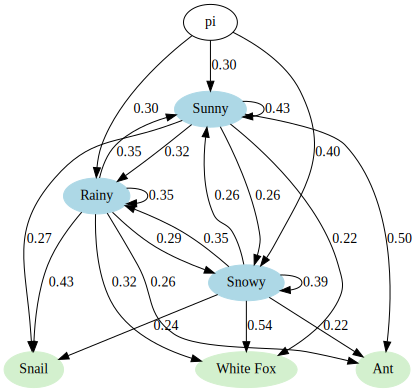

In [4]:
animals_hmm.draw(Q_names, V)

Looking at the plot we can see the probabilities ($\pi$) of starting at specific hidden state, the transition probabilites and the emission probabilities being at each hidden state.

That's all for the Hidden Markov Models introduction. If you want to learn more about them, IMO this [4] notes are a pretty good resource.

Now lets move on to our use case of creating positive *soundish* words.

## Preprocessing corpus

Since our goal is to generate new words, we should work at character level, meaning that characters are going to be the observations and the total number of timesteps, is going to be the word length. For example, a word $W_l$ of length $l$ will be composed of $l$ letters $o_1, o_2, ..., o_l$, in other words, $Wl$ is going to be a sequence of $l$ observations.

Now imagine that the generated word is "hello". In this case, we have:

$W_5 = o_1, o_2, ..., o_5$ where 

$o_1 = h, o_2 = e, o_3 = l, o_4 = l, o_5 = o$

Similar to other Natural Language Processing (NLP) tasks, we cannot work using characters neither words, we have to convert them using a vocabulary.

In [7]:
import string

letters = string.ascii_lowercase + '-+'
letter2idx = {o: i for i, o in enumerate(letters, start=1)} # Reserve 0 for padding

print('hello =', ','.join(str(letter2idx[o]) for o in 'hello'))

hello = 8,5,12,12,15


Once we have a way of converting words into numbers, we can load the dataset and convert some random existing words.  

In [8]:
!wget https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/positive-words.txt

--2020-03-08 10:09:41--  https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/positive-words.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20630 (20K) [text/plain]
Saving to: ‘positive-words.txt.1’

positive-words.txt. 100%[===================>]  20.15K  --.-KB/s    in 0.005s  

2020-03-08 10:09:41 (4.26 MB/s) - ‘positive-words.txt.1’ saved [20630/20630]



In [9]:
import random
random.seed(0)

with open('positive-words.txt') as f:
    dataset = [w.strip() for w in f.readlines() 
               if w.strip() and not w.startswith(';')]

print('Number of words:', len(dataset))
print(random.sample(dataset, 5))

Number of words: 2006
['successfully', 'gallant', 'rosy', 'tops', 'guarantee']


In [10]:
def word2idx(word):
    return [letter2idx[o] for o in word]

random_words = random.sample(dataset, 5)
for w in random_words:
    print(f'{w} =', ','.join(map(str, word2idx(w))))    

altruistic = 1,12,20,18,21,9,19,20,9,3
encouragingly = 5,14,3,15,21,18,1,7,9,14,7,12,25
won = 23,15,14
jubilant = 10,21,2,9,12,1,14,20
innocuous = 9,14,14,15,3,21,15,21,19


Now we can easily convert a word to numbers. Pretty interesting, isn't it? But we want to go a bit further. 

Usually, Machine Learning (ML) models are trained using *batches* of data, and HMMs are not different. So, before moving forward, we need a function that samples $n$ words and packs them into a single tensor. Also, if you are familiar with sequences, you should now that to pack heterogeneous sequences into a single tensor they must have the same size, in other words, they all need to be of size $n$. To achieve that, we usually pad sequences to match the larger sequence inside the batch, which exactly $n$ elements. 

In addition, to avoid computing probabilities involving padding, we keep track of the length of each word in the batch. This will allow us to stop operating at a determined timestep of the sequences (words) and therfore avoid computations with padding.

In [11]:
def sampler(batch_size=32, pad_val=-1):
    batch = random.sample(dataset, batch_size)
    max_len = max(len(o) for o in batch)
    padded_batch = []
    lengths = []
    for b in batch:
        offset = max_len - len(b)
        lengths.append(len(b))
        padded_batch.append(word2idx(b) + [pad_val] * offset)
    
    return np.array(padded_batch), np.array(lengths).astype('int32')

sample_batch = sampler()
print('Batch shape [N_SAMPLES, SEQUENCE_LEN]:', sample_batch[0].shape)

Batch shape [N_SAMPLES, SEQUENCE_LEN]: (32, 15)


We are done here. Let's move on to the training part.

## Training an HMM

In this section, we are going to train an HMM from scratch using the package seen above. 

First of all, we are going to declare an HMM having at least eight possible hidden states and having as many observations as the length of our vocabulary.

> Note that the number of hidden states is arbitrary. With a bigger number of hidden states, we will tend to higher variances (probably overfit), and with low values for hidden states will have a higher bias (higher probability of underfitting). Summarizing, the number of hidden states is an hyperparameter, and you have to play with it in order to improve performance.

In [0]:
import jax

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

words_hmm = hmm.HiddenMarkovModel.random_init(
    key, n_hidden_states=16, n_observations=len(letters) + 1)

To train our HMM, what we need to do, is to tweak the parameters ($A$, $B$ and $\pi$) so they maximize the probability of training words to appear.

If we now sample a word, we are going to see that it does not make any sense. This is because HMM is randomly intialized.

In [48]:
def decode_word(indices):
    vocab = list(letters + '-+')
    return ''.join(vocab[i] if i >= 0 else '<p>' for i in indices)

key, subkey = jax.random.split(key)
generated_word = words_hmm.sample(subkey, timesteps=5) # Sample a word with 5 characters
print('Generated word:', decode_word(generated_word.reshape(-1)))

Generated word: t+cuu


In order to create, words with sense, or at least words pretending to have sense, we are going to maximize the probability of training words. To do so, we are going to use Stochastic Gradient Descent (SGD). More precicely, we are going to compute the gradients of the HMM parameters with respect of Negative Log Likelihood (NLL), and substract a small amount of the gradient to our parameters to maximize the training words likelihood.

$w_{t+1} = w_t - \alpha \frac{\partial L(w_t)}{\partial w_t}$

where $w$ are the HMM parameters and $L$ is the $NLL$.

$NLL = \frac{\sum_{n}{-\log p_i}}{n}$

where $p$ is the probability of a given training word.

Natively, my `hmm` package does not support *batching* with `likelihood` method. Luckily, JAX allow us to vectorize a function by just decorating it with `jax.vmap`. Also, `hmm` module, does not provide a simple way of computing the gradients of the HMM parameters with respect to an error function, but again, JAX provides the decorator `grad` or `value_and_grad` to automatically compute the derivatives of standard python code.

In [0]:
from functools import partial
import hmm.functional as F

# To make F.lokelihood to work with batch, we have to take care of all of its 
# arguments specifying which dimention we want the batch to occur.
# For instance, we do not want the hmm to be batched, but words and lengths should
# be batched on axis 0 
v_likelihood = jax.vmap(F.likelihood, in_axes=(None, 0, 0))

# Computes the NLL given the HMM and training words
def forward(hmm, words, lengths):
    # hmm package works with log probabilities,
    # so likelihood method returns the log probability instead of the *standard one*
    log_prob = v_likelihood(hmm, words, lengths)
    # To compute NLL we just have to neg the probability returned from the 
    # likelihood method
    return -log_prob.mean()

# Partial derivative of first arg (HMM params)
backward = jax.jit(jax.value_and_grad(forward))

If we now call `backward`, the function will return us the loss value and the gradients.

In [42]:
sample_batch = sampler(batch_size=4)
losses, grads = backward(words_hmm, *sample_batch)
print('Loss:', losses)

Loss: 37.04048


If we apply a set of SGD steps with a pretty high learning rate $\alpha$, we are going to see how the loss decreases.

In [43]:
@jax.jit
def train_step(h, words, length):
  losses, grads = backward(h, words, length)
  h = h - grads * 1e-1
  return losses, h

for _ in range(200):
  losses, words_hmm = train_step(words_hmm, *sample_batch)

print('Loss:', losses)

Loss: 33.053852


Reapeat SGD for 1000 steps.

In [0]:
epochs = 10
batch_size = 16
training_steps = len(dataset) // batch_size

for epoch in range(epochs):
  running_loss = 0
  for step in range(training_steps):
      loss, words_hmm = train_step(words_hmm, *sampler())
      running_loss += loss
      
      if (step + 1) % 1000 == 0:
          mean_loss = running_loss / step
          print(f'Step [{epoch}] [{step}/{training_steps}] Loss: {mean_loss:.4f}')
          for i in range(3):
            length = random.randint(4, 10)
            key, subkey = jax.random.split(key)
            generated_w = words_hmm.sample(subkey, length).reshape(-1)
            print('New word:', decode_word(generated_w))

Step [0] [999/5000] Loss: 25.5608
New word: zftzvnmnff
New word: pofm
New word: tiugset
Step [0] [1999/5000] Loss: 25.4192
New word: uofpmtfut
New word: fosfjg
New word: etotf
Step [0] [2999/5000] Loss: 25.3516
New word: djimpbjz
New word: jsdlf
New word: oufohvumfj
Step [0] [3999/5000] Loss: 25.2892
New word: ipouhoiffh
New word: stqslcrcq
New word: ubjsvbfcjo
Step [0] [4999/5000] Loss: 25.2462
New word: zdbijtf
New word: bjof
New word: pkn-
Step [1] [999/5000] Loss: 25.0463
New word: seoee
New word: cfnb
New word: uzof
Step [1] [1999/5000] Loss: 24.9568
New word: bfuzg
New word: mtjzfejsj
New word: bjemsvfdmv
Step [1] [2999/5000] Loss: 24.9208
New word: cjon
New word: bfsfzoi
New word: qugudpbfd
Step [1] [3999/5000] Loss: 24.9087
New word: ejnvb
New word: qeffptftnd
New word: ojzpot
Step [1] [4999/5000] Loss: 24.8793
New word: ghjsoo
New word: s-ge
New word: gwbozdu
Step [2] [999/5000] Loss: 24.6993
New word: xforfn
New word: bfjegbud
New word: swtdssqm
Step [2] [1999/5000] Loss: 24.

In [0]:
key, subkey = jax.random.split(key)
generated_word = words_hmm.sample(subkey, timesteps=5) # Sample a word with 5 characters
print('Generated word:', decode_word(generated_word.reshape(-1)))

We can see how our HMM is creating words that seems that they exists. This is because HMM has *understood* how our language works, in other words, we have created a language model capable of determining the probability of a word existing or not.

That's all for today's blog post, I hope you enjoyed it and I am looking forward to see you again here.


## References

[1] Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
       Proceedings of the ACM SIGKDD International Conference on Knowledge 
       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, 
       Washington, USA, 

[2] Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing 
       and Comparing Opinions on the Web." Proceedings of the 14th 
       International World Wide Web conference (WWW-2005), May 10-14, 
       2005, Chiba, Japan.

[3] Guillem96 - [Implementation of Hidden Markov Models using JAX](https://github.com/Guillem96/jax-hidden-markov-model)

[4] Daniel Jurafsky & James H. Martin - [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/A.pdf)